# Divide the scan into different brain sections 

In [30]:
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
current_dir = os.getcwd()

# let's see how it goes
npy_file_path = os.path.join(current_dir, 'ihb.npy')

all_data = np.load(npy_file_path)

In [31]:
all_data.shape

(320, 10, 246)

In [32]:
import pandas as pd
num_nans = [np.isnan(all_data[i]).sum() for i in range(all_data.shape[0])]
nan_values = pd.Series(num_nans)
nan_values.value_counts()

0      160
460    160
Name: count, dtype: int64

In [33]:
g1 = [all_data[i] for i in range(all_data.shape[0]) if np.isnan(all_data[i]).sum() == 0]
g2 = [all_data[i] for i in range(all_data.shape[0]) if np.isnan(all_data[i]).sum() == 460]

g2_nan_distribution = np.zeros(shape=(len(g2), len(g2)))

for i1, element1 in enumerate(g2):
	for i2, element2 in enumerate(g2):
		g2_nan_distribution[i1][i2] = all(np.sum(np.isnan(element1), axis=1) == np.sum(np.isnan(element2), axis=1))

g2 = [scan[:, :-46] for scan in g2]

# The first step: group scans of the same scan but with different smoothing

In [34]:
# we know for a fact that we have 160 samples belonging to 20 subjects each having

# let's calculate the auto correlation of each time sequence in each of scan
from typing import Union, List
from scipy.signal import correlate2d, correlate

def autocorrelation_stats(scan: np.ndarray, aggregate:bool=True) -> Union[List, float]:	
	assert len(scan) == 10
	auto_correlations =  [float(correlate(scan[i:], scan[:-i])) for i in range(1, 6)]
	if aggregate:
		return np.mean(auto_correlations)
	return auto_correlations

def build_ac_pairs(scans: List[np.ndarray]) -> set:
	auto_corrs = np.zeros(shape=(len(scans), len(scans)))

	for i1, element1 in enumerate(scans):
		for i2, element2 in enumerate(scans):
			auto_corrs[i1][i2] = correlate2d(element1, element2, "valid").item()	
	
	# for each row, row[0] represents the closest index to scan[i] in terms of auto correlation
	# row[1] represents the same index
	paired_scans_by_ac = np.argsort(auto_corrs, axis=-1)[:, -2:]

	pairs = set()

	for i in range(len(scans)):
		assert paired_scans_by_ac[i, 1] == i, "check the code"
		closest_scan_index = paired_scans_by_ac[i, 0]
		if paired_scans_by_ac[closest_scan_index, 0] == i and (closest_scan_index, i) not in pairs:
			pairs.add((i, closest_scan_index)) 

	return pairs

In [35]:
g1_pairs, g2_pairs = build_ac_pairs(g1), build_ac_pairs(g2)

In [36]:
len(g1_pairs), len(g2_pairs)

(80, 80)

In [37]:
def unified_segment_rep(scans: List[np.ndarray], pairs_indices: set) -> List[np.ndarray]:
	avg_segments = []
	for i1, i2 in pairs_indices:
		s1, s2  = scans[i1], scans[i2]
		if s1.shape != s2.shape:
			raise ValueError("Make sure the code is correct. found pairs with different shapes")
		avg_segments.append((s1 + s2) / 2)
	return avg_segments

In [38]:
avg_g1, avg_g2 = unified_segment_rep(g1, g1_pairs), unified_segment_rep(g2, g2_pairs)

In [39]:
def compute_auto_corr_concatenation(seg1: np.ndarray, seg2: np.ndarray):
	assert seg1.shape == seg2.shape, "both segments same shape"
	c_seg1 = np.concatenate([seg1, seg2], axis=0)
	c_seg2 = np.concatenate([seg2, seg1], axis=0)

	assert c_seg1.shape[0] == 2 * seg1.shape[0] and c_seg1.shape[1] == seg1.shape[1], "concatenation correct"
	assert c_seg2.shape[0] == 2 * seg2.shape[0] and c_seg2.shape[1] == seg2.shape[1], "concatenation correct"

	c1 = np.mean([correlate2d(c_seg1[i:i + len(seg1), :], seg1, "valid").item() for i in range(len(seg1))])
	c2 = np.mean([correlate2d(c_seg2[i:i + len(seg1), :], seg2, "valid").item() for i in range(len(seg1))])
	return max(c1, c2)


# One final attempt to match segments belonging to the same sequence

In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def estimate_consecutive_samples(seg1: np.ndarray, seg2: np.ndarray, eval_method: str) -> float:
	if eval_method not in ['avg', 'count']:
		raise NotImplementedError("eval_method non-implemented")

	assert seg1.shape == seg2.shape, "both segments same shape"
	c_seg1 = np.concatenate([seg1, seg2], axis=0)
	c_seg2 = np.concatenate([seg2, seg1], axis=0)


	assert c_seg1.shape[0] == 2 * seg1.shape[0] and c_seg1.shape[1] == seg1.shape[1], "concatenation correct"
	assert c_seg2.shape[0] == 2 * seg2.shape[0] and c_seg2.shape[1] == seg2.shape[1], "concatenation correct"


	scaler = StandardScaler()

	if eval_method == 'count':
		pca1 = PCA(n_components=0.9)
		pca2 = PCA(n_components=0.9)
	else:
		pca1 = PCA(n_components=3)
		pca2 = PCA(n_components=3)

	seg1 = scaler.fit_transform(seg1)
	seg2 = scaler.fit_transform(seg2)

	pca1.fit(seg1)
	pca2.fit(seg2)

	# extract the explained ratio
	var_ratio1 = pca1.explained_variance_ratio_
	var_ratio2 = pca2.explained_variance_ratio_

	if eval_method == 'count':
		return min(len(var_ratio1), len(var_ratio2))

	return max(np.mean(var_ratio1), np.mean(var_ratio2))

In [133]:
def yet_another_estimate(seg1: np.ndarray, seg2: np.ndarray) -> float:
	assert seg1.shape == seg2.shape, "both segments same shape"
	c_seg = np.concatenate([seg1, seg2], axis=0)

	assert c_seg.shape[0] == 2 * seg1.shape[0] and c_seg.shape[1] == seg1.shape[1], "concatenation correct"

	return np.mean(correlate2d(seg1, c_seg, "full")[:,  :len(seg1.shape)]).item()

yet_another_estimate(avg_g1[0], avg_g1[0])

0.01555238615190042

In [41]:
# pca_estimates = np.zeros((len(avg_g1), len(avg_g1)))

# for i in range(len(avg_g1)):
# 	for j in range(i, len(avg_g1)):
# 		pca_estimates[i][j] = estimate_consecutive_samples(avg_g1[i], avg_g1[j], eval_method='avg')
# 		pca_estimates[j][i] = pca_estimates[i][j]

In [42]:
# plt.figure(figsize=(8, 8))
# sns.heatmap(pca_estimates)
# plt.show()

# Reduce 80 to 20: find clusters of 4
Most of the ideas tried to group the differnt time stamps of the same sequence failed. Let's just try to group them

The first step is `feature extraction` from the time series signals. The different possible measures according to this [Nature scientific Report](https://www.nature.com/articles/s41598-020-57915-w) are the following: 

* Pearson's correlation 
* Auto Correlation: seems to work pretty well for us, let's give it a shot
* Mutual Information

In [112]:
def calculate_auto_corr_scan(scan: np.ndarray) -> np.ndarray:
	return correlate2d(scan, scan, "same")

# correlate(avg_g1[0][0], avg_g1[0][0],).shape
f1 = calculate_auto_corr_scan(avg_g1[0])
f1.shape

(10, 246)

In [113]:
g1_ac = np.concatenate([np.mean(calculate_auto_corr_scan(x), axis=0, keepdims=True) for x in avg_g1])
g1_ac.shape
scaler = StandardScaler()
g1_ac = scaler.fit_transform(g1_ac) 

In [114]:
g1_ac.shape

(80, 246)

In [115]:
# use Pca to reduce it
pca = PCA(n_components=0.9, random_state=0)
g1_ac_reduced = pca.fit_transform(g1_ac)

In [116]:
pca.explained_variance_ratio_

array([0.15707637, 0.12567974, 0.10027906, 0.07119732, 0.05425904,
       0.04505014, 0.0330016 , 0.02821455, 0.02294587, 0.0222722 ,
       0.01960771, 0.01793751, 0.01594586, 0.01474107, 0.01409098,
       0.0136403 , 0.01229518, 0.01133829, 0.01090905, 0.01022472,
       0.00949182, 0.00930582, 0.00864933, 0.00854193, 0.00788716,
       0.00757075, 0.00738373, 0.00692346, 0.00668352, 0.00628249,
       0.00596272, 0.00567693, 0.00546646, 0.00517652])

In [87]:
g1_ac_reduced.shape

(80, 34)

In [92]:
from sklearn.manifold import TSNE
t = TSNE(n_components=2, random_state=0)
tsne_embs = t.fit_transform(g1_ac_reduced)

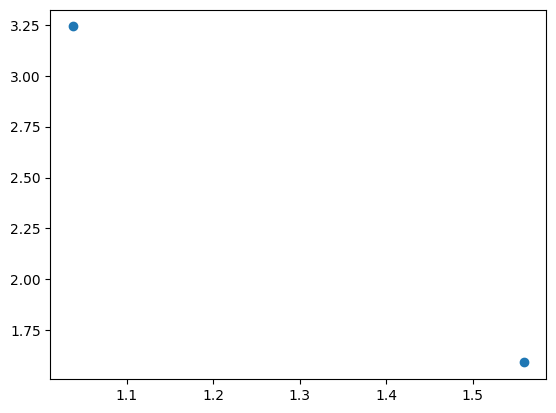

In [93]:
plt.scatter(tsne_embs[0], tsne_embs[1])
plt.show()

In [110]:
# let's see if we can get some decent clusters with this representation
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=20, linkage='single', metric='cosine')

labels = agg.fit_predict(g1_ac_reduced)

In [111]:
pd.Series(labels).value_counts()

1     59
3      2
0      2
16     1
8      1
4      1
5      1
9      1
10     1
7      1
12     1
6      1
15     1
19     1
18     1
14     1
13     1
17     1
11     1
2      1
Name: count, dtype: int64